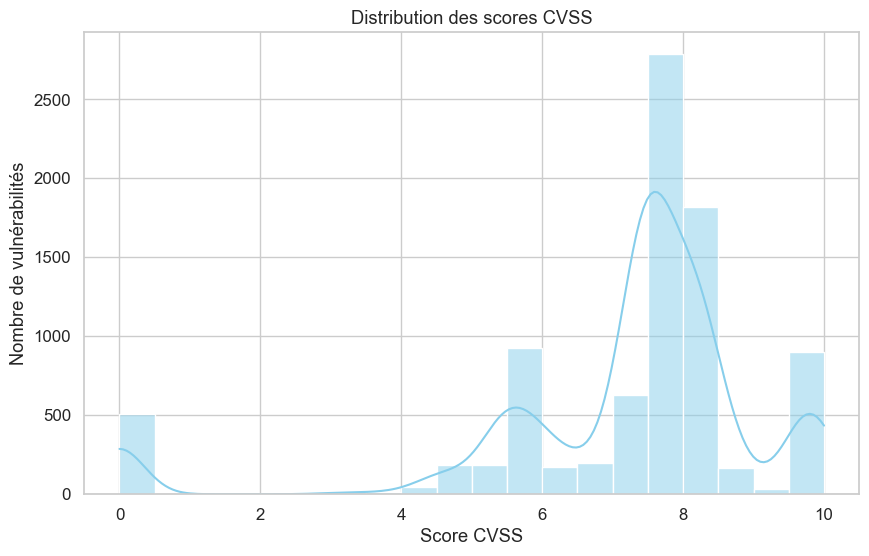

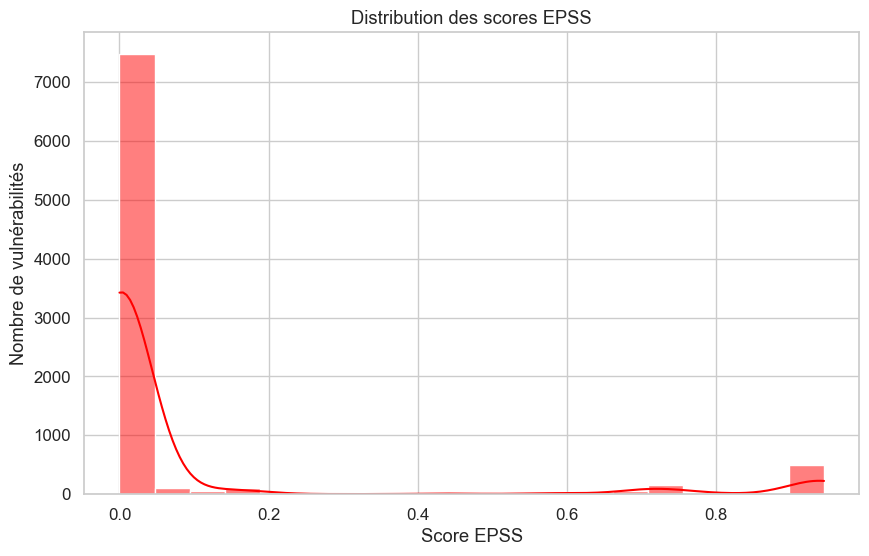

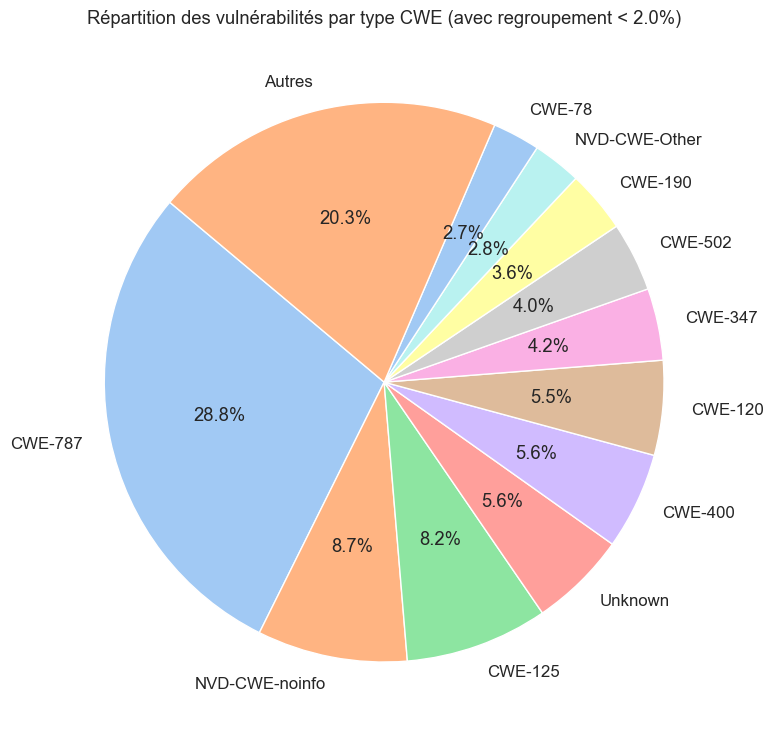

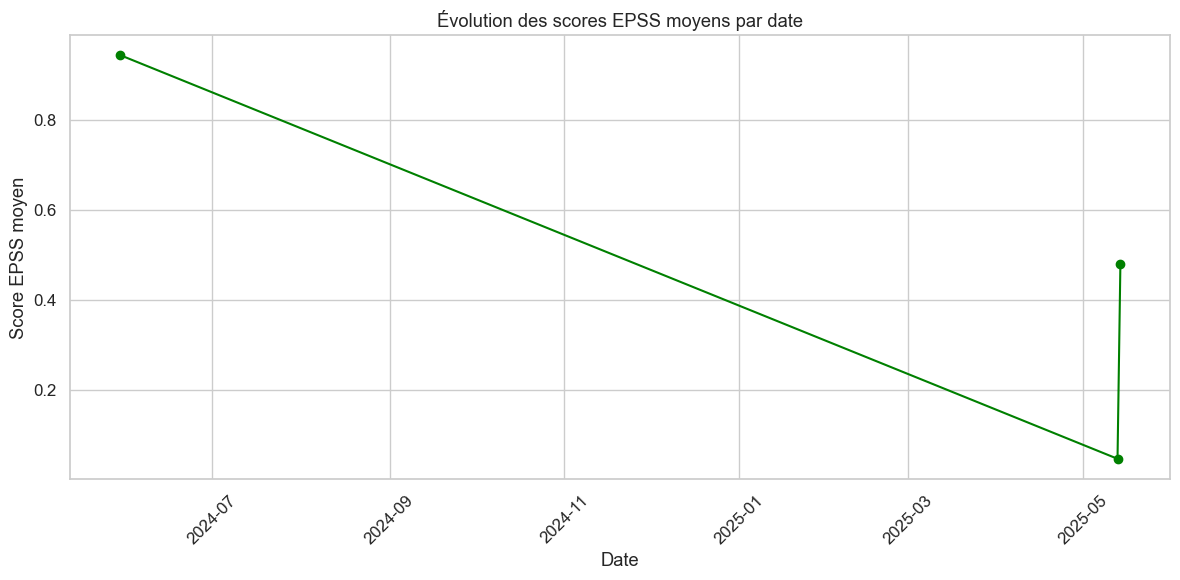

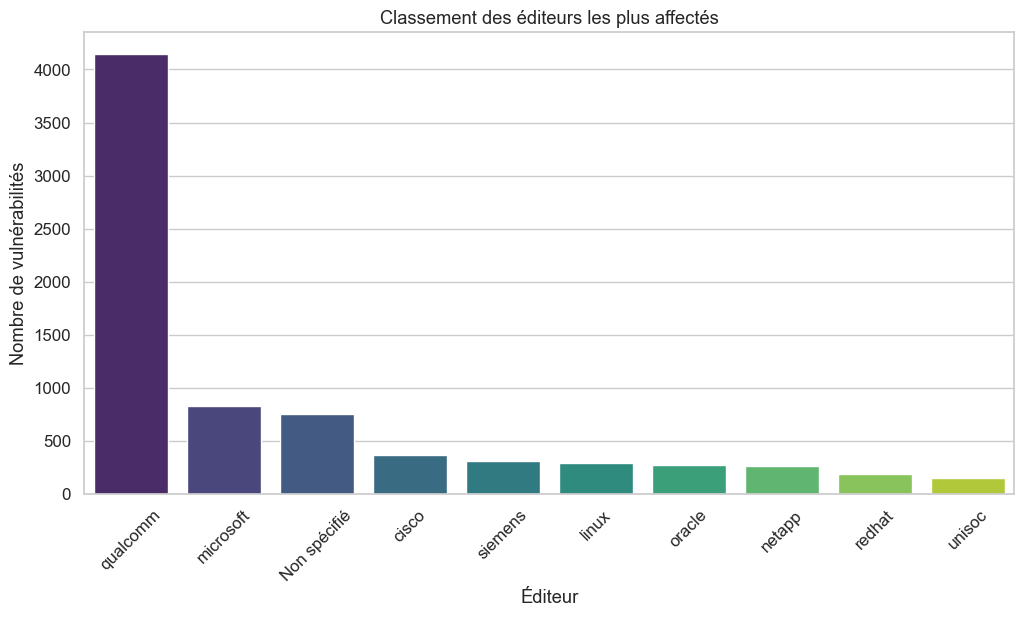

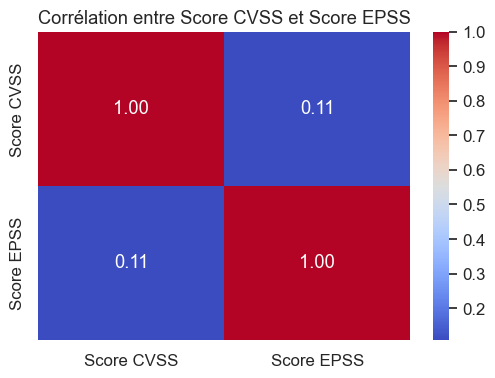

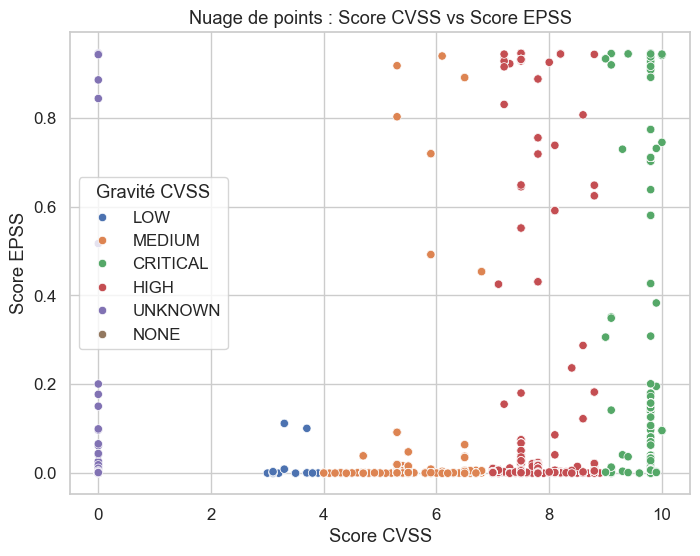

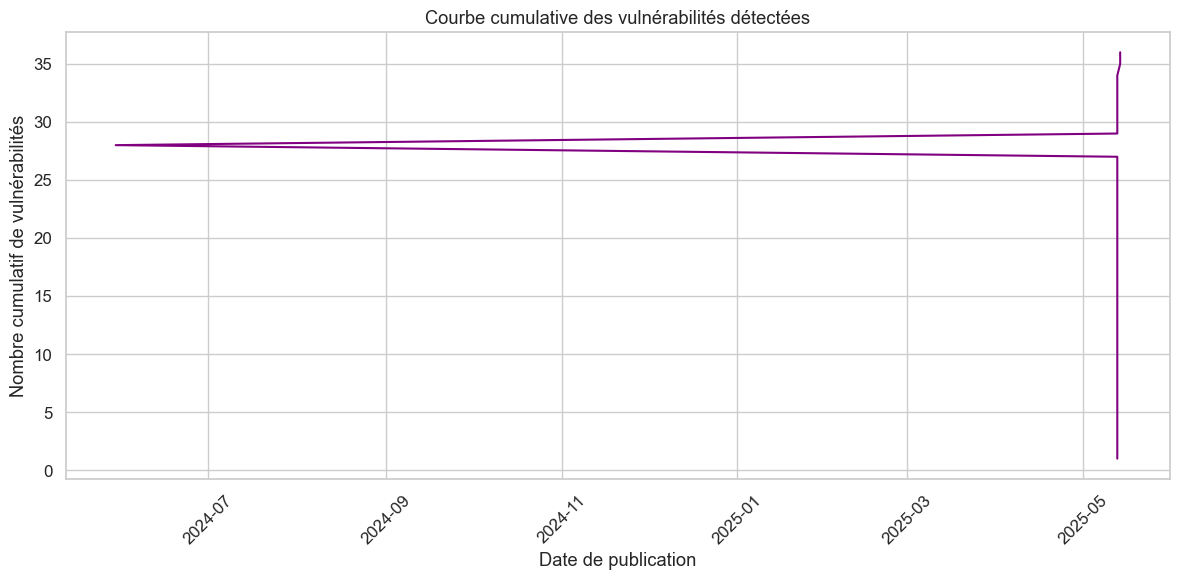

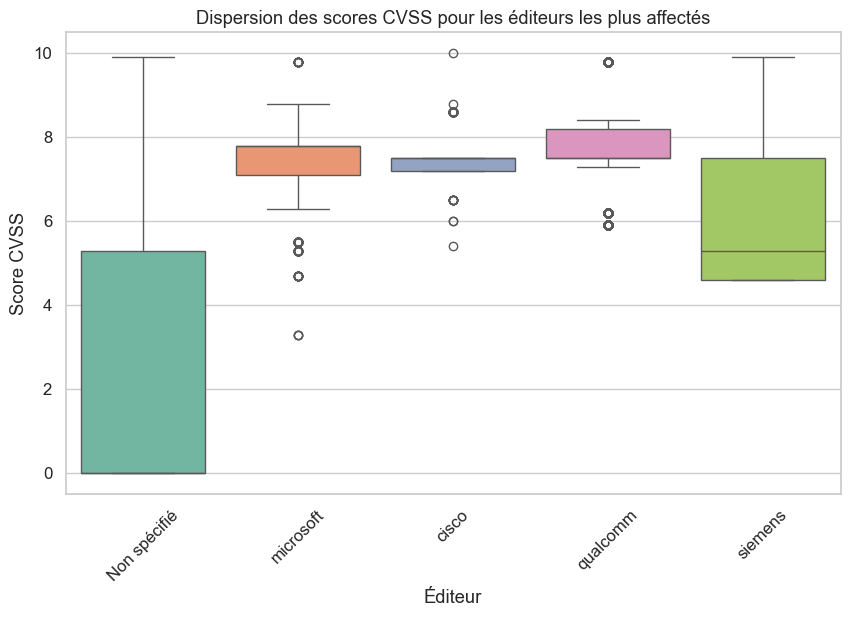

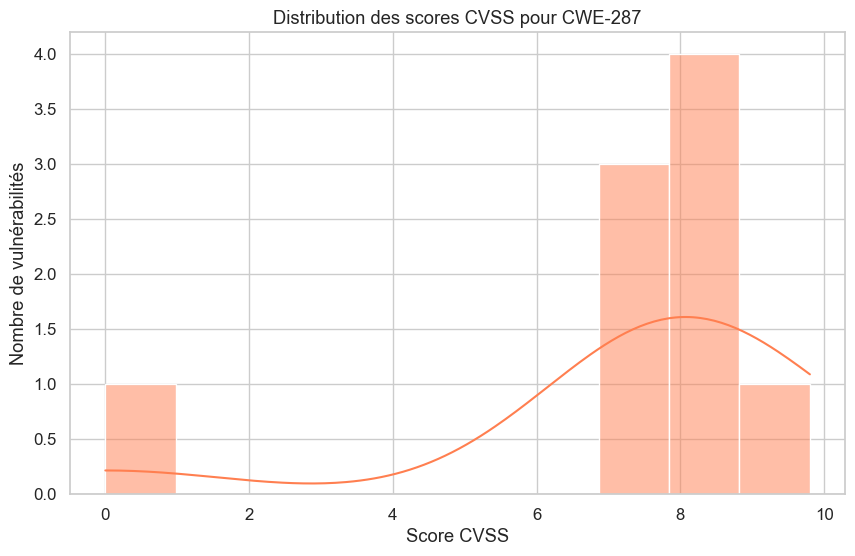

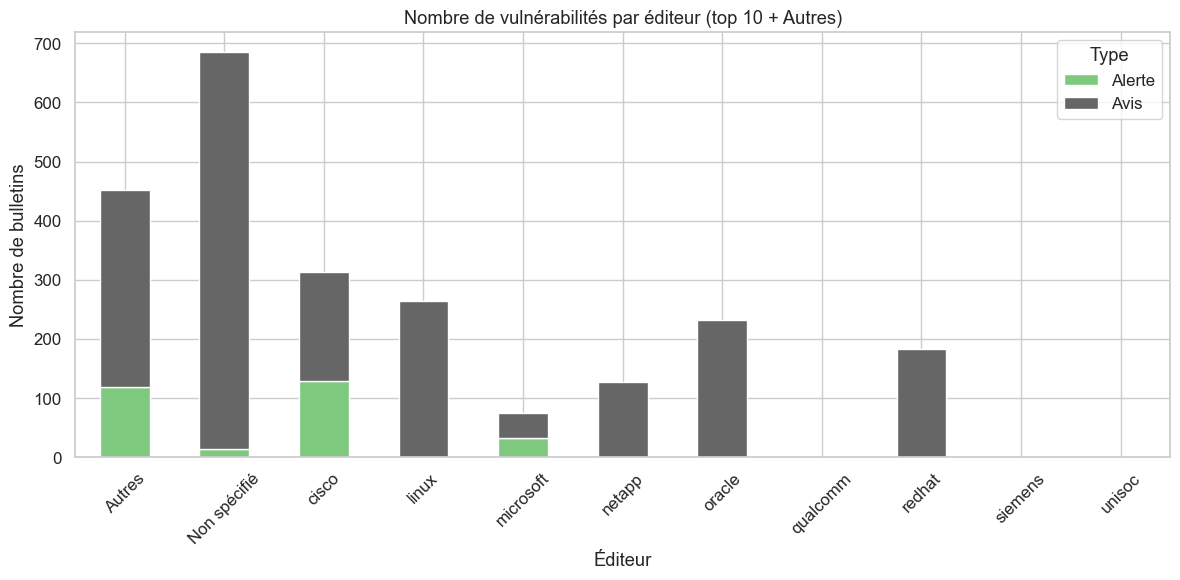

Interprétation et visualisation réalisées. Ces graphiques permettent de prioriser les vulnérabilités critiques, d'identifier les produits et éditeurs les plus touchés ainsi que d'analyser le lien entre le niveau de gravité (CVSS) et la probabilité d'exploitation (EPSS).


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuration de base de seaborn pour les différents plots 
sns.set(font_scale=1.1)
sns.set_style("whitegrid")

df = pd.read_csv("cve_enriched_data_scrapped.csv", encoding='utf-8')

# Conversion de la colonne Date de publication au format datetime
df['Date de publication'] = pd.to_datetime(df['Date de publication'], errors='coerce')
# On peut aussi convertir certains scores en format numérique si nécessaire
df['Score CVSS'] = pd.to_numeric(df['Score CVSS'], errors='coerce')
df['Score EPSS'] = pd.to_numeric(df['Score EPSS'], errors='coerce')

#Différents plots demandés et ajouts
# -- Histogramme des scores CVSS --
plt.figure(figsize=(10,6))
sns.histplot(df['Score CVSS'], bins=20, kde=True, color='skyblue')
plt.title("Distribution des scores CVSS")
plt.xlabel("Score CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.show()

# -- Histogramme des scores EPSS --
plt.figure(figsize=(10,6))
sns.histplot(df['Score EPSS'], bins=20, kde=True, color='red')
plt.title("Distribution des scores EPSS")
plt.xlabel("Score EPSS")
plt.ylabel("Nombre de vulnérabilités")
plt.show()

# -- Diagramme circulaire des types de vulnérabilités (CWE) --
# Comptage des occurrences de chaque type de CWE
cwe_counts = df['Type CWE'].value_counts()
# Calcul du pourcentage de chaque type
cwe_percent = 100 * cwe_counts / cwe_counts.sum()
# Séparer les types fréquents et ceux à regrouper
seuil = 2.0
cwe_major = cwe_percent[cwe_percent >= seuil]
cwe_minor = cwe_percent[cwe_percent < seuil]
# Regrouper les petits types sous "Autres"
cwe_grouped = cwe_major.copy()
cwe_grouped['Autres'] = cwe_minor.sum()
# Création du diagramme circulaire
plt.figure(figsize=(8,8))
plt.pie(
    cwe_grouped,
    labels=cwe_grouped.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel', len(cwe_grouped))
)
plt.title("Répartition des vulnérabilités par type CWE (avec regroupement < 2.0%)")
plt.tight_layout()
plt.show()


# -- Courbe des scores EPSS moyen par date --
# On trie les données par date et calcule la moyenne des scores EPSS par date
df_sorted = df.sort_values('Date de publication')
daily_epss = df_sorted.groupby(df_sorted['Date de publication'].dt.date)['Score EPSS'].mean()
plt.figure(figsize=(12,6))
plt.plot(daily_epss.index, daily_epss.values, marker='o', linestyle='-', color='green')
plt.title("Évolution des scores EPSS moyens par date")
plt.xlabel("Date")
plt.ylabel("Score EPSS moyen")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -- Classement des éditeurs les plus affectés --
# Ici, nous comptons le nombre de vulnérabilités par éditeur et affichons les 10 premiers
editor_counts = df['Éditeur'].value_counts().head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=editor_counts.index, y=editor_counts.values, hue=editor_counts.index, palette='viridis', legend=False)
plt.title("Classement des éditeurs les plus affectés")
plt.xlabel("Éditeur")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.show()

# -- Heatmap des corrélations entre CVSS et EPSS --
corr = df[['Score CVSS', 'Score EPSS']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélation entre Score CVSS et Score EPSS")
plt.show()

# -- Nuage de points entre Score CVSS et Score EPSS --
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Score CVSS', y='Score EPSS', hue='Gravité CVSS', palette='deep')
plt.title("Nuage de points : Score CVSS vs Score EPSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.show()

# -- Courbe cumulative des vulnérabilités au fil du temps --
df_sorted = df.dropna(subset=['Date de publication']).copy()
# Convertir la colonne en format datetime et supprimer le fuseau horaire
df_sorted['Date de publication'] = pd.to_datetime(df_sorted['Date de publication'], errors='coerce').dt.tz_localize(None)
# Vérifier et supprimer les valeurs NaT restantes
df_sorted = df_sorted.dropna(subset=['Date de publication'])

# Générer la courbe cumulative
df_sorted['Cumulative Count'] = np.arange(1, len(df_sorted) + 1)
plt.figure(figsize=(12,6))
plt.plot(df_sorted['Date de publication'], df_sorted['Cumulative Count'], color='purple')
plt.title("Courbe cumulative des vulnérabilités détectées")
plt.xlabel("Date de publication")
plt.ylabel("Nombre cumulatif de vulnérabilités")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# -- Boxplot des scores CVSS par éditeur --
# On se focalise sur les 5 éditeurs les plus fréquents
top_editors = df['Éditeur'].value_counts().head(5).index
plt.figure(figsize=(10,6))
sns.boxplot(x='Éditeur', y='Score CVSS', data=df[df['Éditeur'].isin(top_editors)], hue='Éditeur', palette='Set2', legend=False)
plt.title("Dispersion des scores CVSS pour les éditeurs les plus affectés")
plt.xlabel("Éditeur")
plt.ylabel("Score CVSS")
plt.xticks(rotation=45)
plt.show()

# -- Visualisation particulière pour un type de CWE défini --
# Exemple : pour le CWE "CWE-287" (à adapter selon vos données)
cwe_specific = df[df['Type CWE'] == 'CWE-287']
plt.figure(figsize=(10,6))
sns.histplot(cwe_specific['Score CVSS'], bins=10, kde=True, color='coral')
plt.title("Distribution des scores CVSS pour CWE-287")
plt.xlabel("Score CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.show()


# -- Analyse des vulnérabilités par éditeur et par type de bulletin (avis ou alertes) --
editor_counts = df['Éditeur'].value_counts()
top_editors = editor_counts.head(10).index
df['Éditeur simplifié'] = df['Éditeur'].apply(lambda x: x if x in top_editors else 'Autres')

editor_type = df.groupby(['Éditeur simplifié', 'Type'])['ID ANSSI'].count().unstack().fillna(0)
editor_type.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Accent')
plt.title("Nombre de vulnérabilités par éditeur (top 10 + Autres)")
plt.xlabel("Éditeur")
plt.ylabel("Nombre de bulletins")
plt.xticks(rotation=45)
plt.legend(title="Type")
plt.tight_layout()
plt.show()


# Message de fin d'analyse
print("Interprétation et visualisation réalisées. Ces graphiques permettent de prioriser les vulnérabilités critiques, d'identifier les produits et éditeurs les plus touchés ainsi que d'analyser le lien entre le niveau de gravité (CVSS) et la probabilité d'exploitation (EPSS).")
